# Variational Autoencoders
Dhanush Kamath | [GitHub](https://github.com/dhanushkamath) | [LinkedIn](https://www.linkedin.com/in/dhanushkamath/)

This notebook assumes that you are fairly familiar with the concepts of Convolutional Neural Networks and representation learning. If not, I would recommend watching Andrej Karpathy's [CS231n lecture videos](https://www.youtube.com/playlist?list=PLkt2uSq6rBVctENoVBg1TpCC7OQi31AlC) as they are, in my honest opinion, the best resource for learning CNNs on the internet. You can also find the lecture notes for the course [here](http://cs231n.github.io/).

If you're beginning to explore the field of Generative Deep Learning, a Variational Autoencoder (VAE) is ideal to kick off your journey. The VAE architecture is intuitive and simple to understand. Contrary to a discriminative model such as a CNN classifier, a generative model attempts to learn the underlying distribution of the data rather than classifying the data into one of many categories. A well trained CNN classifier would be highly accurate in differentiating an image of a car from that of a house. However, this does not accomplish our objective of generating images of cars and houses.

This example demonstrates the process of building and training a VAE using Keras to generate new faces. We shall be using the [CelebFaces Attributes (CelebA) Dataset](https://www.kaggle.com/jessicali9530/celeba-dataset) from Kaggle and [Google Colab](https://colab.research.google.com/) for training the VAE model.

## HOUSEKEEPING

### Downloading the dataset
The dataset can be downloaded directly into your Google Colab environment using the [Kaggle API](https://www.kaggle.com/docs/api) as shown below. You can refer to this [post](https://medium.com/@opalkabert/downloading-kaggle-datasets-into-google-colab-fb9654c94235) on Medium for more details.

In [0]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle

Upload Kaggle.json downloaded from your registered kaggle account

In [5]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mrhighsenberg","key":"a36743de919ff3e5b6461430aace7e96"}'}

In [0]:
!cp kaggle.json ~/.kaggle/
!kaggle datasets download -d jessicali9530/celeba-dataset

In [0]:
!mkdir data
!mkdir run

#Unzip the dataset downloaded from kaggle
from zipfile import ZipFile
with ZipFile('celeba-dataset.zip', 'r') as zipObj:
   # Extract all the contents of zip file in the data directory
   zipObj.extractall('./data/')

Caution (for Colab users) : Do not attempt to explore the directory using the viewer on the left as the page becomes unresponsive owing to the large size of the dataset.

### Imports

In [8]:
import os
from glob import glob
import numpy as np

from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation, BatchNormalization, LeakyReLU, Dropout
from keras.models import Model
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint 
from keras.utils import plot_model

Using TensorFlow backend.


### Run parameters

In [0]:
RUN_ID = '0001'
RUN_FOLDER = 'run/{}/'.format(RUN_ID)

if not os.path.exists(RUN_FOLDER):
    os.mkdir(RUN_FOLDER)
    os.mkdir(os.path.join(RUN_FOLDER, 'weights'))

DATA_FOLDER = './data/img_align_celeba/'

###Data

In [10]:
filenames = np.array(glob(os.path.join(DATA_FOLDER, '*/*.jpg')))
NUM_IMAGES = len(filenames)
print("Total number of images : " + str(NUM_IMAGES))

Total number of images : 202599


As the dataset is quite large, we shall create an <i>ImageDataGenerator</i> object and employ it's member function - <i>flow_from_directory</i> to define the flow of data directly from disk rather than loading the entire dataset into memory. The ImageDataGenerator can also be used to dynamically apply various transformations for image augmentation which is particularly useful in the case of small datasets.

I highly encourage you to refer to the [documentation](https://keras.io/preprocessing/image/#flow_from_directory) for understanding the various parameters of the dataflow function. 

In [11]:
INPUT_DIM = (128,128,3) # Image dimension
BATCH_SIZE = 512
Z_DIM = 200 # Dimension of the latent vector (z)

data_flow = ImageDataGenerator(rescale=1./255).flow_from_directory(DATA_FOLDER, 
                                                                   target_size = INPUT_DIM[:2],
                                                                   batch_size = BATCH_SIZE,
                                                                   shuffle = True,
                                                                   class_mode = 'input',
                                                                   subset = 'training'
                                                                   )

Found 202599 images belonging to 1 classes.


## SIMPLE AUTOENCODER

Before delving into a Variational Autoencoder, it is crucial to analyse a simple Autoencoder. 

A simple or Vanilla Autoencoder consists of two neural networks - an Encoder and a Decoder. An Encoder is responsible for converting an image into a compact lower dimensional vector (or latent vector). This latent vector is a compressed representation of the image. The Encoder therfore maps an input from the higher dimensional input space to the lower dimensional latent space. This is similar to a CNN classifier. In a CNN classifier, this latent vector would be subsequently fed into a softmax layer to compute individual class probabilities. However in an Autoencoder, these outputs are fed into the Decoder. The Decoder is a different neural network that tries to reconstruct the image, thereby mapping from the lower dimenstional latent space to the higher dimensional output space. The Encoder and Decoder therefore perform mappings that are exactly opposite to each other, as shown in the image <i>img-1</i>. 


<br>
<img src="https://upload.wikimedia.org/wikipedia/commons/2/28/Autoencoder_structure.png"> 
<br><i>img-1</i>
<br><i>Source : en.wikipedia.org/wiki/Autoencoder</i>

<br><br>
Consider the following analogy to understand this better. Imagine you're playing a game with your friend over the phone. The rules of the game are simple. You are presented with a number of different cylinders. Your task is to describe the cylinders to your friend who will then attempt to recreate them out of modelling clay. You are forbidden from sending pictures. How will you convey this information? 

Since any cylinder can be constructed with two parameters - its height and diameter, the most efficient strategy would be to estimate these two measures and convey them to your friend. Your friend, upon receiving this information can then reconstruct the cylinder. In this example, it is quite evident that you are performing the function of an Encoder by condensing visual information into two quantities. Your friend on the contrary, is performing the function of a Decoder by utilising this condensed information to recreate the cylinder.




### Encoder Architecture


####Building the Encoder

In [0]:
# ENCODER
def build_encoder(input_dim, output_dim, conv_filters, conv_kernel_size, 
                  conv_strides):
  
  # Clear tensorflow session to reset layer index numbers to 0 for LeakyRelu, 
  # BatchNormalization and Dropout.
  # Otherwise, the names of above mentioned layers in the model 
  # would be inconsistent
  global K
  K.clear_session()
  
  # Number of Conv layers
  n_layers = len(conv_filters)

  # Define model input
  encoder_input = Input(shape = input_dim, name = 'encoder_input')
  x = encoder_input

  # Add convolutional layers
  for i in range(n_layers):
      x = Conv2D(filters = conv_filters[i], 
                  kernel_size = conv_kernel_size[i],
                  strides = conv_strides[i], 
                  padding = 'same',
                  name = 'encoder_conv_' + str(i)
                  )(x)

      x = LeakyReLU()(x)
    
  # Required for reshaping latent vector while building Decoder
  shape_before_flattening = K.int_shape(x)[1:] 
  
  x = Flatten()(x)

  # Define model output
  encoder_output = Dense(output_dim, name = 'encoder_output')(x)

  return encoder_input, encoder_output, shape_before_flattening, Model(encoder_input, encoder_output)

<br><br>
The architecture of the Encoder, as shown below, consists of a stack of convolutional layers followed by a dense (fully connected) layer which outputs a vector of size 200.


<i>Note : The combination of padding = 'same' and stride = 2 will produce an output tensor half the size of the input tensor in both height and width. The depth/channels aren't affected as they are numerically equal to the number of filters. </i>
<br><br>

In [13]:
encoder_input, encoder_output,  shape_before_flattening, encoder  = build_encoder(input_dim = INPUT_DIM,
                                    output_dim = Z_DIM, 
                                    conv_filters = [32, 64, 64, 64],
                                    conv_kernel_size = [3,3,3,3],
                                    conv_strides = [2,2,2,2])

encoder.summary()






Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 128, 128, 3)       0         
_________________________________________________________________
encoder_conv_0 (Conv2D)      (None, 64, 64, 32)        896       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64, 64, 32)        0         
_________________________________________________________________
encoder_conv_1 (Conv2D)      (None, 32, 32, 64)        18496     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 32, 32, 64)        0         
_________________________________________________________________
encoder_conv_2 (Conv2D)      (None, 16, 16, 64)        36928     
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16, 16, 64)       

####Building the Decoder


In [0]:
# Decoder
def build_decoder(input_dim, shape_before_flattening, conv_filters, conv_kernel_size, 
                  conv_strides):

  # Number of Conv layers
  n_layers = len(conv_filters)

  # Define model input
  decoder_input = Input(shape = (input_dim,) , name = 'decoder_input')

  # To get an exact mirror image of the encoder
  x = Dense(np.prod(shape_before_flattening))(decoder_input)
  x = Reshape(shape_before_flattening)(x)

  # Add convolutional layers
  for i in range(n_layers):
      x = Conv2DTranspose(filters = conv_filters[i], 
                  kernel_size = conv_kernel_size[i],
                  strides = conv_strides[i], 
                  padding = 'same',
                  name = 'decoder_conv_' + str(i)
                  )(x)
      
      # Adding a sigmoid layer at the end to restrict the outputs 
      # between 0 and 1
      if i < n_layers - 1:
        x = LeakyReLU()(x)
      else:
        x = Activation('sigmoid')(x)

  # Define model output
  decoder_output = x

  return decoder_input, decoder_output, Model(decoder_input, decoder_output)

<br><br>
Recall that the it is the function of the Decoder to reconstruct the image from the latent vector. Therefore it is necessary to define the decoder so as to increase the size of the activations gradually through the network. This can be achieved either through the [UpSampling2D](https://keras.io/layers/convolutional/#upsampling2d) layer or the [Conv2DTransponse](https://keras.io/layers/convolutional/#conv2dtranspose) layer.

Here the Conv2DTranspose Layer is employed. This layer produces an output tensor double the size of the input tensor in both height and width.

<i>Note : The Decoder, in this example, is defined to be a mirror image of the encoder, which is not mandatory.</i>

<br><br>

In [15]:
decoder_input, decoder_output, decoder = build_decoder(input_dim = Z_DIM,
                                        shape_before_flattening = shape_before_flattening,
                                        conv_filters = [64,64,32,3],
                                        conv_kernel_size = [3,3,3,3],
                                        conv_strides = [2,2,2,2]
                                        )
decoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 4096)              823296    
_________________________________________________________________
reshape_1 (Reshape)          (None, 8, 8, 64)          0         
_________________________________________________________________
decoder_conv_0 (Conv2DTransp (None, 16, 16, 64)        36928     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
decoder_conv_1 (Conv2DTransp (None, 32, 32, 64)        36928     
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 32, 32, 64)        0   

#### Attaching the Decoder to the Encoder

In [16]:
# The input to the model will be the image fed to the encoder.
simple_autoencoder_input = encoder_input

# Output will be the output of the decoder. The term - decoder(encoder_output) 
# combines the model by passing the encoder output to the input of the decoder.
simple_autoencoder_output = decoder(encoder_output)

# Input to the combined model will be the input to the encoder.
# Output of the combined model will be the output of the decoder.
simple_autoencoder = Model(simple_autoencoder_input, simple_autoencoder_output)

simple_autoencoder.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 128, 128, 3)       0         
_________________________________________________________________
encoder_conv_0 (Conv2D)      (None, 64, 64, 32)        896       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64, 64, 32)        0         
_________________________________________________________________
encoder_conv_1 (Conv2D)      (None, 32, 32, 64)        18496     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 32, 32, 64)        0         
_________________________________________________________________
encoder_conv_2 (Conv2D)      (None, 16, 16, 64)        36928     
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16, 16, 64)        0   

### COMPILATION AND TRAINING

The loss function used is a simple Root Mean Square Error (RMSE). The true output is the same batch of images that was fed to the model at it's input layer. The Adam optimizer is optimizing the RMSE error for encoding the batch of images into their respective latent vectors and subsequently decoding them to reconstruct the images. 

In [17]:
LEARNING_RATE = 0.0005
N_EPOCHS = 10

optimizer = Adam(lr = LEARNING_RATE)

def r_loss(y_true, y_pred):
    return K.mean(K.square(y_true - y_pred), axis = [1,2,3])

simple_autoencoder.compile(optimizer=optimizer, loss = r_loss)

<i>TIP</i> : Here's a really useful tip I found on Reddit (by arvind1096) - to prevent Google Colab from disconnecting due to a timeout issue, execute the following JS function in the Google Chrome console. 

<br>
function ClickConnect(){console.log("Working");document.querySelector("colab-toolbar-button#connect").click()}setInterval(ClickConnect,60000)

In [0]:
simple_autoencoder.fit_generator(data_flow, 
                                 shuffle=True, 
                                 epochs = N_EPOCHS, 
                                 initial_epoch = 0, 
                                 steps_per_epoch=NUM_IMAGES / BATCH_SIZE)

Epoch 1/10
396/395 [==============================] - 213s 539ms/step - loss: 0.0294
Epoch 2/10
396/395 [==============================] - 214s 540ms/step - loss: 0.0108
Epoch 3/10
396/395 [==============================] - 214s 540ms/step - loss: 0.0091
Epoch 4/10
396/395 [==============================] - 213s 538ms/step - loss: 0.0083
Epoch 5/10
396/395 [==============================] - 213s 538ms/step - loss: 0.0079
Epoch 6/10
396/395 [==============================] - 212s 537ms/step - loss: 0.0077
Epoch 7/10
396/395 [==============================] - 213s 539ms/step - loss: 0.0075
Epoch 8/10
396/395 [==============================] - 212s 536ms/step - loss: 0.0073
Epoch 9/10
396/395 [==============================] - 212s 536ms/step - loss: 0.0072
Epoch 10/10
396/395 [==============================] - 212s 535ms/step - loss: 0.0071


Saving the model architecture and weights to disc for reuse.

NOTE : If you're using Google Colab, either download the weights to disc or mount your Google Drive.

In [0]:
simple_autoencoder.save_weights("ae_weights.h5")

### RECONSTRUCTION

The first step is to generate a new batch of images using the ImageDataGenerator defined in the 'Data' section at the top. The images are returned as an array and the number of images is equal to BATCH_SIZE. 

In [0]:
example_batch = next(data_flow)
example_batch = example_batch[0]
example_images = example_batch[:10]

In [0]:
example_images.shape

(10, 128, 128, 3)

#### Displaying the reconstructed images

In [0]:
import matplotlib.pyplot as plt

In [0]:
def plot_compare(images=None, add_noise=False):
  
  if images is None:
    example_batch = next(data_flow)
    example_batch = example_batch[0]
    images = example_batch[:10]

  n_to_show = images.shape[0]

  if add_noise:
    encodings = encoder.predict(images)
    encodings += np.random.normal(0.0, 1.0, size = (n_to_show,200))
    reconst_images = decoder.predict(encodings)

  else:
    reconst_images = simple_autoencoder.predict(images)

  fig = plt.figure(figsize=(15, 3))
  fig.subplots_adjust(hspace=0.4, wspace=0.4)

  for i in range(n_to_show):
      img = images[i].squeeze()
      sub = fig.add_subplot(2, n_to_show, i+1)
      sub.axis('off')        
      sub.imshow(img)

  for i in range(n_to_show):
      img = reconst_images[i].squeeze()
      sub = fig.add_subplot(2, n_to_show, i+n_to_show+1)
      sub.axis('off')
      sub.imshow(img)  

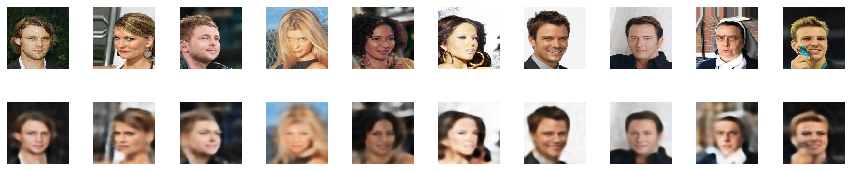

In [0]:
plot_compare(example_images)

The first row shows images directly from the dataset and the second row shows images that have been passed through the Autoencoder. As is evident, the model has learned to encode and decode (reconstruct) fairly well. 

NOTE : A reason why the images lack sharpness is due to the RMSE loss as it averages out the differences between individual pixel values. Generative Adversarial Networks on the contrary, produce much sharper images.

### DRAWBACKS

#### Adding noise vectors sampled from a standard normal distribution to the image encodings

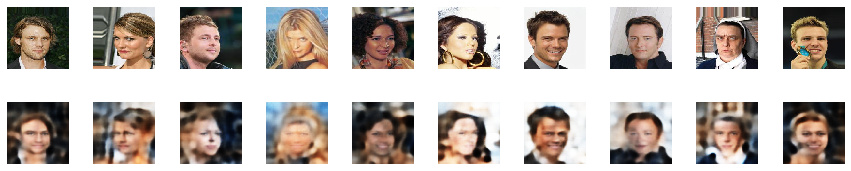

In [0]:
plot_compare(images = example_images, add_noise = True)

It can be observed that the images are starting to get distorted with a little bit of noise added to it's encodings. One possible reason could be that the model did not ensure that the space around the encoded values (latent space) is continuous.

### Attempting to generate images from latent vectors sampled from a standard normal distribution

In [0]:
 def generate_images_from_noise(n_to_show = 10): 
  reconst_images = decoder.predict(np.random.normal(0,1,size=(n_to_show,Z_DIM)))

  fig = plt.figure(figsize=(15, 3))
  fig.subplots_adjust(hspace=0.4, wspace=0.4)

  for i in range(n_to_show):
      img = reconst_images[i].squeeze()
      sub = fig.add_subplot(2, n_to_show, i+1)
      sub.axis('off')        
      sub.imshow(img)

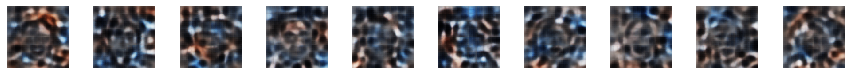

In [0]:
generate_images_from_noise()

It is evident that the latent vector sampled from a standard normal distribution can not be used to generate new faces. This shows that the latent vectors generated by the model are not centered/symmetrical around the origin. This also strengthens our inference that the latent space is not continuous.

## VARIATIONAL AUTOENCODER



Variational Autencoders tackle most of the problems discussed above. They are trained to generate new faces from latent vectors sampled from a standard normal distribution. While a Simple Autoencoder learns to map each image into a fixed point in the latent space, the Encoder of a Variational Autoencoder (VAE) maps each image to a Z-dimensional standard normal distribution. 



#### How can a simple Autoencoder be modified to make the encoder map to a z-dimensional standard normal distribution?

Any Z-dimensional normal distribution can be represented by a mean vector $\mu$ and a covariance matrix $\Sigma$.

<br>
<center>
$\mu= \begin{pmatrix} \mu_1\\ \vdots \\\mu_z \end{pmatrix},
\ \ \ \Sigma =
\begin{pmatrix} \sigma_1^2 & \rho\sigma_1\sigma_2 & \cdots &   \rho\sigma_1\sigma_z   
\\ \rho\sigma_2\sigma_1 & \sigma_z^2 & \cdots & \rho\sigma_2\sigma_z
\\ \vdots & \vdots & \ddots & \vdots 
\\ \rho\sigma_z\sigma_1 & \rho\sigma_z\sigma_2 & \cdots & \sigma_z^2 \end{pmatrix}
$
</center>
<br><br>

<b>Therefore, in the case of a VAE, the encoder should output  a mean vector ($\mu$) and a covariance matrix ($\Sigma$) to map to a normal distribution, right?</b>

Yes, however, there are slight modifications to be made to the covariance matrix $\Sigma$.

<b>Modification 1) </b>It is assumed that there is no correlation between the elements of the latent vector. Hence, the non diagonal elements, representing covariance, are all zeroes. The covariance matrix is therefore, a diagonal matrix.

<br>
<center>
$\Sigma =\begin{pmatrix} \sigma_1^2 & 0 & \cdots & 0  
\\ 0 & \sigma_z^2 & \cdots & 0
\\ \vdots & \vdots & \ddots & \vdots 
\\ 0 & 0 & \cdots & \sigma_z^2 \end{pmatrix}$
</center>
<br>

As the diagonal elements of this matrix represent variance, it is simply represented as $\sigma^2$, a Z-dimensional variance vector.

<br>
<center>
$\sigma^2 =\begin{pmatrix} \sigma_1^2 
\\ \vdots  
\\ \sigma_z^2 \end{pmatrix}$
</center>
<br>

<b>Modification 2) </b> Recall that the variance can only take non-negative values. To ensure that the output of the encoder is unbounded, the encoder is actually mapped to the mean vector and the <b>logarithm</b> of the variance vector. The logarithm ensures that the output can now take up any value in the range, $(-\infty,\infty)$. This makes training easier as the outputs of the neural network are naturally unbounded.

<b>Now how is it ensured that the Encoder maps to a standard normal distribution (i.e, with a mean of 0 and a standard deviation of 1)?</b>

Enter KL divergence.

<b>KL divergence</b> provides a measurement of how much one probability distribution differs from another. The KL divergence between a distribution with mean $\mu$ and standard deviation $\sigma\$, and the standard normal distribution, takes up the form,

<br>
<center>
$D_{KL}[N(\mu,\sigma) \ || \ N(0,1)] = \frac{1}{2}\sum_{i=1}^{z}(1+\log(\sigma_i^2) - \mu_i^2 - \sigma_i^2)$
</center>
</br>


By slightly modifying the loss function to include the KL divergence loss in addition to the RMSE loss, the VAE is forced to ensure that the encodings are very similar to a multivariate standard normal distribution. Since a multivariate standard normal distribution has a zero mean, it is obviously centered around the origin. Mapping each image to a standard normal distribution as opposed to a fixed point ensures that the latent space is continuous and the latent vectors are centered around the origin.

Take a look at the image <i>img-2</i> for a better understanding.

<br>
<img src="https://blog.bayeslabs.co/assets/img/vae.jpg"> 
<br><i>img-2</i>
<br><i>Source : blog.bayeslabs.co/2019/06/04/All-you-need-to-know-about-Vae</i>



#### If the encoder maps to $\mu$ and $\sigma$ instead of a Z-dimensional latent vector, what's the input given to the Decoder during training?

The input to the Decoder, as shown in <i>img-2</i>, is a vector sampled from the normal distribution represented by the output of the Encoder - $\mu$ and $\sigma$. This sampling can be done as follows - 

<center>
$Z = \mu + \sigma\varepsilon$
</center>

where $\varepsilon$ is sampled from a standard normal distribution.



#### How do we generate new faces?

Since the KL divergence ensures that the encoder maps as close to a standard normal distribution as possible, we can simply sample from a z-dimensional standard normal distribution and feed it to the decoder to generate new images.

#### Does the decoder require any modification?
No, the decoder remains the same. It is identical to that of a Simple Autoencoder.

### CODE

#### Building the Encoder


In [0]:
# ENCODER
def build_vae_encoder(input_dim, output_dim, conv_filters, conv_kernel_size, 
                  conv_strides, use_batch_norm = False, use_dropout = False):
  
  # Clear tensorflow session to reset layer index numbers to 0 for LeakyRelu, 
  # BatchNormalization and Dropout.
  # Otherwise, the names of above mentioned layers in the model 
  # would be inconsistent
  global K
  K.clear_session()
  
  # Number of Conv layers
  n_layers = len(conv_filters)

  # Define model input
  encoder_input = Input(shape = input_dim, name = 'encoder_input')
  x = encoder_input

  # Add convolutional layers
  for i in range(n_layers):
      x = Conv2D(filters = conv_filters[i], 
                  kernel_size = conv_kernel_size[i],
                  strides = conv_strides[i], 
                  padding = 'same',
                  name = 'encoder_conv_' + str(i)
                  )(x)
      if use_batch_norm:
        x = BathcNormalization()(x)
  
      x = LeakyReLU()(x)

      if use_dropout:
        x = Dropout(rate=0.25)(x)

  # Required for reshaping latent vector while building Decoder
  shape_before_flattening = K.int_shape(x)[1:] 
  
  x = Flatten()(x)
  
  mean_mu = Dense(output_dim, name = 'mu')(x)
  log_var = Dense(output_dim, name = 'log_var')(x)

  # Defining a function for sampling
  def sampling(args):
    mean_mu, log_var = args
    epsilon = K.random_normal(shape=K.shape(mean_mu), mean=0., stddev=1.) 
    return mean_mu + K.exp(log_var/2)*epsilon   
  
  # Using a Keras Lambda Layer to include the sampling function as a layer 
  # in the model
  encoder_output = Lambda(sampling, name='encoder_output')([mean_mu, log_var])

  return encoder_input, encoder_output, mean_mu, log_var, shape_before_flattening, Model(encoder_input, encoder_output)

In [39]:
vae_encoder_input, vae_encoder_output,  mean_mu, log_var, vae_shape_before_flattening, vae_encoder  = build_vae_encoder(input_dim = INPUT_DIM,
                                    output_dim = Z_DIM, 
                                    conv_filters = [32, 64, 64, 64],
                                    conv_kernel_size = [3,3,3,3],
                                    conv_strides = [2,2,2,2])

vae_encoder.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
encoder_conv_0 (Conv2D)         (None, 64, 64, 32)   896         encoder_input[0][0]              
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 64, 64, 32)   0           encoder_conv_0[0][0]             
__________________________________________________________________________________________________
encoder_conv_1 (Conv2D)         (None, 32, 32, 64)   18496       leaky_re_lu_1[0][0]              
____________________________________________________________________________________________

#### Building the Decoder
Since the Decoder remains the same, the Eecoder architecture of the Simple Autoencoder is reused.

In [40]:
vae_decoder_input, vae_decoder_output, vae_decoder = build_decoder(input_dim = Z_DIM,
                                        shape_before_flattening = shape_before_flattening,
                                        conv_filters = [64,64,32,3],
                                        conv_kernel_size = [3,3,3,3],
                                        conv_strides = [2,2,2,2]
                                        )
vae_decoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 4096)              823296    
_________________________________________________________________
reshape_1 (Reshape)          (None, 8, 8, 64)          0         
_________________________________________________________________
decoder_conv_0 (Conv2DTransp (None, 16, 16, 64)        36928     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
decoder_conv_1 (Conv2DTransp (None, 32, 32, 64)        36928     
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 32, 32, 64)        0   

#### Attaching the Decoder to the Encoder


In [41]:
# The input to the model will be the image fed to the encoder.
vae_input = vae_encoder_input

# Output will be the output of the decoder. The term - decoder(encoder_output) 
# combines the model by passing the encoder output to the input of the decoder.
vae_output = vae_decoder(vae_encoder_output)

# Input to the combined model will be the input to the encoder.
# Output of the combined model will be the output of the decoder.
vae_model = Model(vae_input, vae_output)

vae_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
encoder_conv_0 (Conv2D)         (None, 64, 64, 32)   896         encoder_input[0][0]              
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 64, 64, 32)   0           encoder_conv_0[0][0]             
__________________________________________________________________________________________________
encoder_conv_1 (Conv2D)         (None, 32, 32, 64)   18496       leaky_re_lu_1[0][0]              
____________________________________________________________________________________________

### COMPILATION AND TRAINING


The loss function is a sum of RMSE and KL Divergence. A weight is assigned to the RMSE loss, known as the loss factor. The loss factor is multiplied with the RMSE loss. If we use a high loss factor, the drawbacks of a Simple Autoencoder start to appear. However, if the loss factor is too low, the quality of the reconstructed images will be poor. Hence the loss factor is a hyperparameter that needs to be tuned.

In [0]:
LEARNING_RATE = 0.0005
N_EPOCHS = 200
LOSS_FACTOR = 10000

In [0]:
def kl_loss(y_true, y_pred):
    kl_loss =  -0.5 * K.sum(1 + log_var - K.square(mean_mu) - K.exp(log_var), axis = 1)
    return kl_loss

def total_loss(y_true, y_pred):
    return LOSS_FACTOR*r_loss(y_true, y_pred) + kl_loss(y_true, y_pred)

In [0]:
adam_optimizer = Adam(lr = LEARNING_RATE)

vae_model.compile(optimizer=adam_optimizer, loss = total_loss, metrics = [r_loss, kl_loss])

In [45]:
vae_model.fit_generator(data_flow, 
                        shuffle=True, 
                        epochs = N_EPOCHS, 
                        initial_epoch = 0, 
                        steps_per_epoch=NUM_IMAGES / BATCH_SIZE)




Epoch 1/200





396/395 [==============================] - 223s 563ms/step - loss: 393.7629 - r_loss: 0.0349 - kl_loss: 44.6684
Epoch 2/200
396/395 [==============================] - 209s 527ms/step - loss: 240.1462 - r_loss: 0.0185 - kl_loss: 55.1771
Epoch 3/200
396/395 [==============================] - 212s 535ms/step - loss: 224.3742 - r_loss: 0.0167 - kl_loss: 57.5385
Epoch 4/200
396/395 [==============================] - 212s 535ms/step - loss: 218.1353 - r_loss: 0.0159 - kl_loss: 58.8713
Epoch 5/200
396/395 [==============================] - 209s 527ms/step - loss: 214.1881 - r_loss: 0.0155 - kl_loss: 59.5719
Epoch 6/200
396/395 [==============================] - 208s 525ms/step - loss: 211.4100 - r_loss: 0.0152 - kl_loss: 59.8775
Epoch 7/200
396/395 [==============================] - 206s 521ms/step - loss: 209.3111 - r_loss: 0.0149 - kl_loss: 60.0011
Epoch 8/200
396/395 [==============================] - 205s 517ms/step - loss: 207.6045 - r_loss: 0.0148 - kl_loss: 60.0822


KeyboardInterrupt: ignored

KeyboardInterrupt: ignored

In [0]:
vae_model.save_weights('vae_weights.h5')

### RECONSTRUCTION.
The reconstruction process is the same as that of the Simple Autoencoder.

In [0]:
example_batch = next(data_flow)
example_batch = example_batch[0]
example_images = example_batch[:10]

In [0]:
def plot_compare_vae(images=None):
  
  if images is None:
    example_batch = next(data_flow)
    example_batch = example_batch[0]
    images = example_batch[:10]

  n_to_show = images.shape[0]
  reconst_images = vae_model.predict(images)

  fig = plt.figure(figsize=(15, 3))
  fig.subplots_adjust(hspace=0.4, wspace=0.4)

  for i in range(n_to_show):
      img = images[i].squeeze()
      sub = fig.add_subplot(2, n_to_show, i+1)
      sub.axis('off')        
      sub.imshow(img)

  for i in range(n_to_show):
      img = reconst_images[i].squeeze()
      sub = fig.add_subplot(2, n_to_show, i+n_to_show+1)
      sub.axis('off')
      sub.imshow(img)  

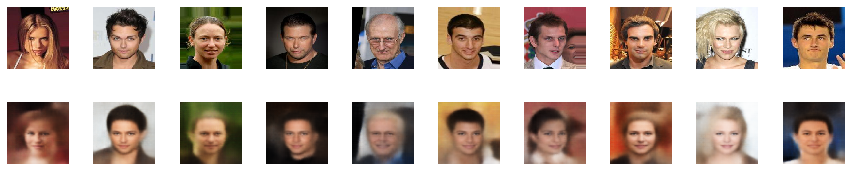

In [55]:
plot_compare_vae(images = example_images)

### Generating new faces from random vectors sampled from a standard normal distribution. 

In [0]:
def vae_generate_images(n_to_show=10):
  reconst_images = vae_decoder.predict(np.random.normal(0,1,size=(n_to_show,Z_DIM)))

  fig = plt.figure(figsize=(15, 3))
  fig.subplots_adjust(hspace=0.4, wspace=0.4)

  for i in range(n_to_show):
        img = reconst_images[i].squeeze()
        sub = fig.add_subplot(2, n_to_show, i+1)
        sub.axis('off')        
        sub.imshow(img)

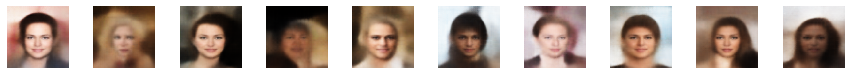

In [65]:
vae_generate_images(n_to_show=10)

The VAE is evidently capable enough of producing new faces from vectors samped from a standard normal distribution. The fact that a neural network is capable of generating new faces from random noise shows how powerful they are in performing extremely complex mappings!

As it is impossible to visualize a 200 dimensional vector, some of the elements of the latent vector are individually visualized to see if they are close to a standard normal distribution.

In [0]:
from scipy.stats import norm

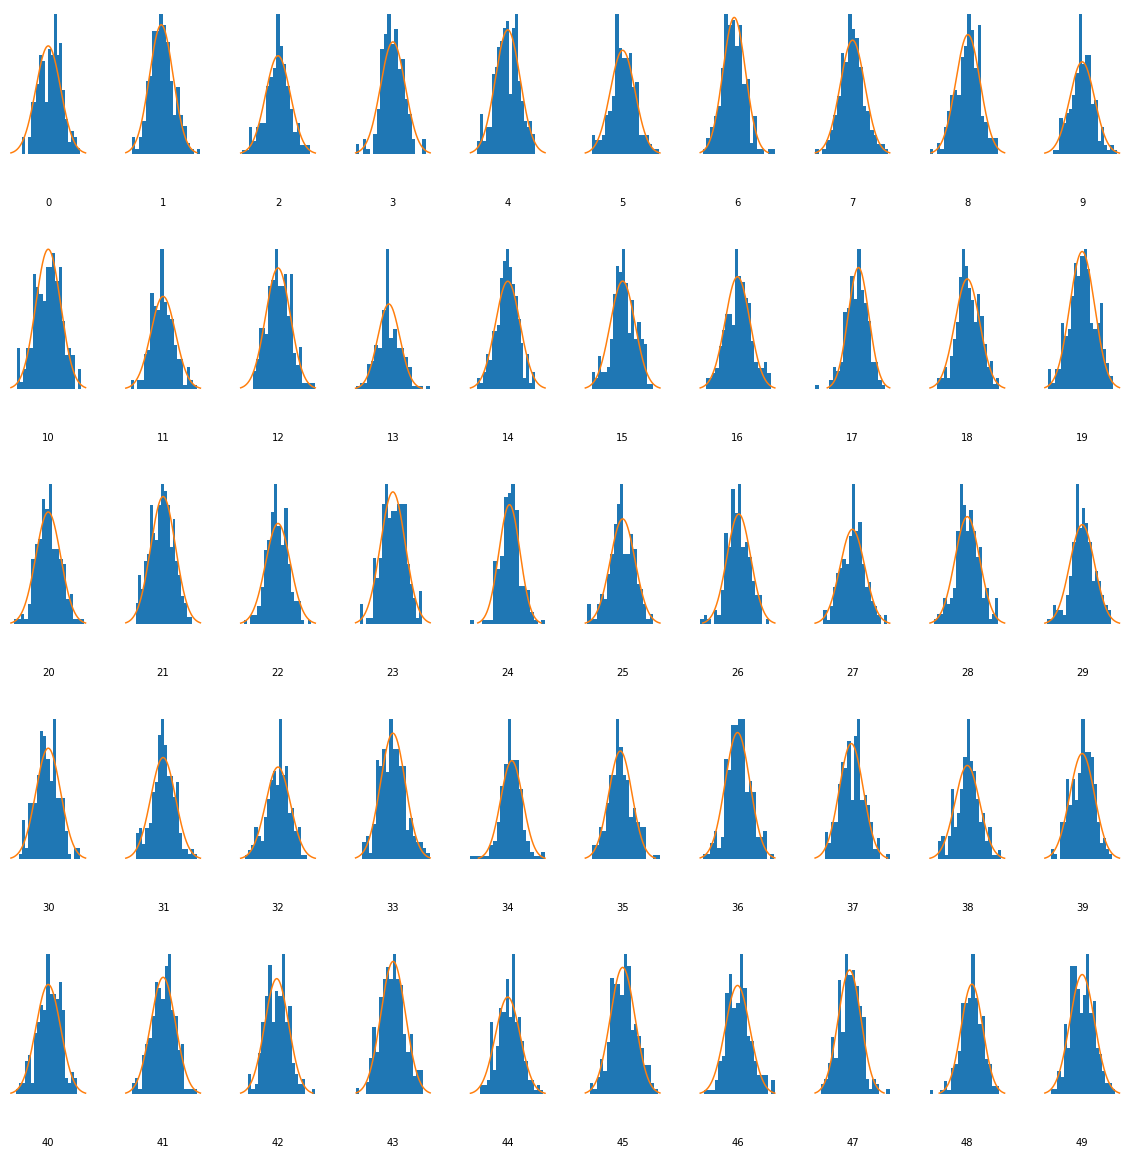

In [60]:
z_test = vae_encoder.predict(example_batch[:200])

x = np.linspace(-3, 3, 300)

fig = plt.figure(figsize=(20, 20))
fig.subplots_adjust(hspace=0.6, wspace=0.4)

for i in range(50):
    ax = fig.add_subplot(5, 10, i+1)
    ax.hist(z_test[:,i], density=True, bins = 20)
    ax.axis('off')
    ax.text(0.5, -0.35, str(i), fontsize=10, ha='center', transform=ax.transAxes)
    ax.plot(x,norm.pdf(x))

plt.show()

It is observed that the first 50 elements of the Z dimensional vector are very similar to a standard normal distribution. The addition of the KL divergence term is therefore, justified. 